
## Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje



## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de una bicicleta durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: datos, dicccionario de datos.

## Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)
# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour
# Visualización
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


## Punto 1 - Análisis descriptivo


Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables hour y workingday, escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('workingday').total.mean()

workingday
0    188.506621
1    193.011873
Name: total, dtype: float64

Si el día no es un festivo o día feriado su media de alquiler tiene una media inferior para cuando es un día feriado. Es decir se tiende alquilar más bicicletas en días feriados . 

In [5]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

Con esta tabla , se muestra el comprotamiento de la demanda de bicicletas para cada hora. Como se puede observar , la hora que tiene más alto flujo es a las 8 de la mañana y la de menor es a las 4 de la mañana

In [6]:
#Celda 1.3

bikes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  total       10886 non-null  int64  
 11  hour        10886 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 1.1 MB


No se presentan datos nulos para niguno de los datos del dataset

In [7]:
#Celda 1.4 

bikes.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000


- Variables del DataSet:

season -  1 = spring, 2 = summer, 3 = fall, 4 = winter . Variable categorica define el tiempo en que se demanda la bicicleta
holiday - whether the day is considered a holiday. Variable categorica que considera si esta en vacaciones o no ante la demanda la bicicleta.

workingday - whether the day is neither a weekend nor holiday. Variable categorica que considera si esta en vacaciones o no ante la demanda la bicicleta.

weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy. Variable categorica que considera el estado del clima ante la demanda la bicicleta.

temp - temperature in Celsius. Variable que registra la temperatura en celsius. La misma  promedio es de 20 grados celsius , en donde la minima llegó a 0.8 grados C y la maxima de 41 grados C.

atemp - "feels like" temperature in Celsius. Variable que registra la temperatura de acuerdo a la subjetividad del demandante.
humidity - relative humidity. Variable que registra la humedad . En promedio esta está en 61 y el 75% de los datos está a más de 77.

windspeed - wind speed . Variable que registra la velocidad del viento. Su promedio de velocidad media es de 12 mph y la máxima velocidad es de 56.

casual - number of non-registered user rentals initiated. Variable que registra personas no registradas en la demanda de ciclas. Su promedio es de 50 registros.  

registered - number of registered user rentals initiated. Variable de personas registradas que demandan las ciclas. Este es mucho mayor ya que su promedio es de 151 y alcanzó a tener un máximo de 886 registros.

count - number of total rentals . Variable de respuesta que toma en cuenta las rentas realizadas. 

## PUNTO 2 ANALISIS GRÁFICO

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica de las rentas promedio por hora cuando la variable "workingday" es igual a 0 e igual a 1, respectivamente. Analice y escriba sus hallazgos.

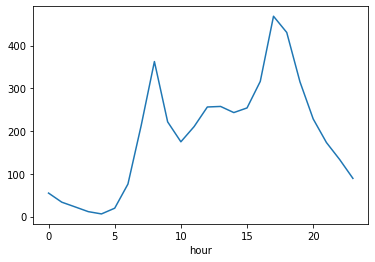

In [8]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

Se observa el comprotamiento promedio que se presenta dentro de cada hora del día en cuanto a la demanda presentada. Como se había mencionado anteriormente, las horas en donde menos se demandan ciclas es entre la media noche y 5 de la mañana. Sin embargo se presenta un incremento pronunciado , generando dos máximos presentados . Uno en horas de la mañana cercano a las 10am y el otro en horas de la tarde entre las 3 pm y 6pm.

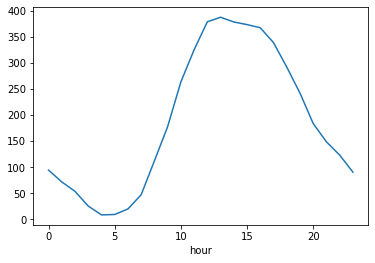

In [9]:
# Celda 2.2 - "workingday"=0 escriba su código y hallazgos 


clase_0 = bikes[bikes['workingday'] == 0]
clase_0.groupby('hour').total.mean().plot()


Para la clase 0 de la variable workingday se observa que las horas pico de demanda de ciclas se da entre las 10 de la mañana y las 4 de la tarde. En este grupo se ve solo un periodo valle y uno de repunte. 

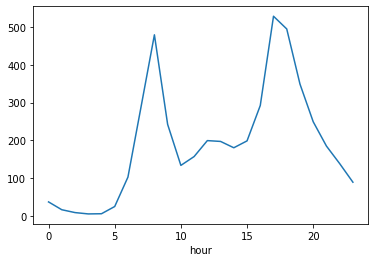

In [10]:
# Celda 2.3 - "workingday"=1 escriba su código y hallazgos 

clase_1 = bikes[bikes['workingday'] == 1]
clase_1.groupby('hour').total.mean().plot()

A diferencia del anterior grupo. Para este se ven 2 intervalo de tiempo como picos. Estos son entre las 7 y 9 de la mañana apróximadamente ; y entre las 4 y 6 de la tarde.

## Punto 3 - Regresión lineal

En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "hour" y "workingday" como las únicas variables predictoras. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [11]:

# División de los datos en train y test
 
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy import stats
    

X = bikes[["workingday","hour"]]
y = bikes["total"]

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.67,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [12]:
# Creación del modelo utilizando matrices como en scikitlearn
# ==============================================================================
# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
X_train = sm.add_constant(X_train, prepend=True)
modelo1 = sm.OLS(endog=y_train, exog=X_train,)
modelo1 = modelo1.fit()
print(modelo1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     658.5
Date:                Sun, 03 Apr 2022   Prob (F-statistic):          1.25e-263
Time:                        23:24:21   Log-Likelihood:                -47715.
No. Observations:                7293   AIC:                         9.544e+04
Df Residuals:                    7290   BIC:                         9.546e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         70.1508      4.727     14.840      0.0

El modelo con  las variables seleccionadas como predictores tiene un  R2  bajo (0.15), es capaz de "explicar" solamente el 15% de la variabilidad observada en las renta de bicicletas. El p-value del modelo es "significativo" (1.25e-263) por lo que se puede aceptar , al menos uno de los coeficientes parciales de regresión es distinto de 0.

Yendo a las variables. Se puede resumir que las variables  Workinday y hour llegan a tener un impacto positivo en la variable de respuesta.Sin embargo la variable Workingday es no significativa para el modelo  P>|t|- 0.05.



In [13]:
# Intervalos de confianza para los coeficientes del modelo manteniendo la variable no significativa

intervalos_ci = modelo1.conf_int(alpha=0.05)
intervalos_ci.columns = ['2.5%', '97.5%']
intervalos_ci

,2.5%,97.5%
const,60.884179,79.417481
workingday,-3.502200,13.098484
hour,9.686590,10.794816


In [14]:
# Predicciones con intervalo de confianza 

prediccionesREG = modelo1.get_prediction(exog = X_train).summary_frame(alpha=0.05)
prediccionesREG.head(4)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
datetime,,,,,,
2011-07-13 21:00:00,290.003741,3.555604,283.033728,296.973755,-39.356064,619.363547
2011-02-11 20:00:00,279.763038,3.350755,273.194589,286.331487,-49.588514,609.114591
2012-07-18 09:00:00,167.115302,2.492419,162.229438,172.001165,-162.206990,496.437594
2011-09-19 15:00:00,228.559522,2.559448,223.542262,233.576782,-100.764746,557.883790


In [21]:
# Error de test del modelo y F1 Score
from sklearn import metrics

X_test = sm.add_constant(X_test, prepend=True)
predicciones= modelo1.predict(exog = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print("")
print(f"El error (rmse) de test es: {rmse}")



El error (rmse) de test es: 161.87434227064566


Mantiendo las 2 variables indicadas y sacando las respectivas predicciones, se observa que su error es alto. Aunque de momento no hay una comparación con otro modelo esto resulta ser una limitación para poder seleccionarlo además que el mismo no tiene un gran porcentaje de explicabilidad por las variables seleccioandas. 

## Punto 4 - Árbol de decisión manual

En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando manualmente sobre las variables "hour" y "workingday". El árbol debe tener al menos 6 nodos finales.

In [22]:
# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

In [23]:
# Impresión variable a usar (Hour)
j = 1
print(X.columns[j])

hour


In [24]:
# División de la variable Hour en num_ctp puntos (parámetro definido anteriormente) para obtener posibles puntos de corte
splits = np.percentile(X.iloc[:,j], np.arange(0, 100, 100.0 / num_pct).tolist())
splits = np.unique(splits)
splits

array([ 0.,  2.,  4.,  7.,  9., 12., 14., 16., 19., 21.])

In [25]:
# División de las observaciones usando el punto de corte en la posición 6 de la lista de splits
k=6
filter_l = X.iloc[:, j] < splits[k]

# División de la variable de respuesta de acuerdo a si la observación cumple o no con la regla binaria
# y_l: la observación tiene un valor menor al punto de corte seleccionado
# y_r: la observación tiene un valor mayor o igual al punto de corte seleccionado
y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]
y_r

datetime
2011-01-01 14:00:00    106
2011-01-01 15:00:00    110
2011-01-01 16:00:00     93
2011-01-01 17:00:00     67
2011-01-01 18:00:00     35
                      ... 
2012-12-19 19:00:00    336
2012-12-19 20:00:00    241
2012-12-19 21:00:00    168
2012-12-19 22:00:00    129
2012-12-19 23:00:00     88
Name: total, Length: 4560, dtype: int64

In [26]:
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [27]:
# Gini index de las observaciones que tienen un valor menor al punto de corte seleccionado
gini_l = gini(y_l)
gini_l

-38009.443289361094

In [28]:
# Gini index de las observaciones que tienen un valor mayor o igual al punto de corte seleccionado
gini_r = gini(y_r)
gini_r

-140342.5905278547

In [29]:
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [30]:
# Ganancia de la variable 'Hours' en el punto de corte selecionado
gini_impurity(X.iloc[:, j], y, splits[k])

7857.284071891307

In [31]:
# Impresión variable a usar (Workday)
J = 0
print(X.columns[J])

workingday


In [32]:
# División de la variable Workingdat en num_ctp puntos (parámetro definido anteriormente) para obtener posibles puntos de corte
splits_ = np.percentile(X.iloc[:, J], np.arange(0, 100, 100.0 / num_pct).tolist())
splits_ = np.unique(splits_)
splits_

array([0., 1.])

In [33]:
# División de las observaciones usando el punto de corte en la posición 5 de la lista de splits_

filter_l_ = X.iloc[:, J] < splits[k]

# División de la variable de respuesta de acuerdo a si la observación cumple o no con la regla binaria
# y_l: la observación tiene un valor menor al punto de corte seleccionado
# y_r: la observación tiene un valor mayor o igual al punto de corte seleccionado
y_l_ = y.loc[filter_l_]
y_r_ = y.loc[~filter_l_]
y_l_

datetime
2011-01-01 00:00:00     16
2011-01-01 01:00:00     40
2011-01-01 02:00:00     32
2011-01-01 03:00:00     13
2011-01-01 04:00:00      1
                      ... 
2012-12-19 19:00:00    336
2012-12-19 20:00:00    241
2012-12-19 21:00:00    168
2012-12-19 22:00:00    129
2012-12-19 23:00:00     88
Name: total, Length: 10886, dtype: int64

In [34]:
# Gini index de las observaciones que tienen un valor menor al punto de corte seleccionado
gini_l_ = gini(y_l_)
gini_l_

-73018.14777226778

In [35]:
# Gini index de las observaciones que tienen un valor mayor o igual al punto de corte seleccionado
gini_r_ = gini(y_r_)
gini_r_

0

In [36]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [37]:
# Obtención de la variable 'j', su punto de corte 'split' y su ganancia 'gain'
j, split, gain = best_split(X, y, 5)
j, split, gain

(1, 8.0, 18268.811823533004)

In [38]:
# División de las observaciones usando la mejor variable 'j' y su punto de corte 'split'
filter_l = X.iloc[:, j] < split

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [39]:
y.shape[0], y_l.shape[0], y_r.shape[0]

(10886, 3594, 7292)

In [40]:
y.mean(), y_l.mean(), y_r.mean()

(191.57413191254824, 55.437673900946024, 258.6715578716402)

In [48]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [50]:
# Aplicación de la función tree_grow
tree_grow(X, y, level=0, min_gain=0.001, max_depth=2, num_pct=10)

{'y_pred': 1,
 'y_prob': 191.53903379867745,
 'level': 0,
 'split': [1, 8.0],
 'n_samples': 10886,
 'gain': 18268.811823533004,
 'sl': {'y_pred': 1,
  'y_prob': 55.40711902113459,
  'level': 1,
  'split': [1, 7.0],
  'n_samples': 3594,
  'gain': 7207.700659959655,
  'sl': {'y_pred': 1,
   'y_prob': 32.561604584527224,
   'level': 2,
   'split': -1,
   'n_samples': 3139,
   'gain': 646.8008927589567},
  'sr': {'y_pred': 1,
   'y_prob': 212.18599562363238,
   'level': 2,
   'split': -1,
   'n_samples': 455,
   'gain': 25730.857340927716}},
 'sr': {'y_pred': 1,
  'y_prob': 258.6007677543186,
  'level': 1,
  'split': [1, 21.0],
  'n_samples': 7292,
  'gain': 7392.920792160614,
  'sl': {'y_pred': 1,
   'y_prob': 287.7910901113736,
   'level': 2,
   'split': -1,
   'n_samples': 5924,
   'gain': 5136.949194485263},
  'sr': {'y_pred': 1,
   'y_prob': 131.95985401459853,
   'level': 2,
   'split': -1,
   'n_samples': 1368,
   'gain': 1818.4488902568337}}}

In [51]:
tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=3, num_pct=10)
tree

{'y_pred': 1,
 'y_prob': 191.53903379867745,
 'level': 0,
 'split': [1, 8.0],
 'n_samples': 10886,
 'gain': 18268.811823533004,
 'sl': {'y_pred': 1,
  'y_prob': 55.40711902113459,
  'level': 1,
  'split': [1, 7.0],
  'n_samples': 3594,
  'gain': 7207.700659959655,
  'sl': {'y_pred': 1,
   'y_prob': 32.561604584527224,
   'level': 2,
   'split': [1, 6.0],
   'n_samples': 3139,
   'gain': 646.8008927589567,
   'sl': {'y_pred': 1,
    'y_prob': 25.15934475055845,
    'level': 3,
    'split': -1,
    'n_samples': 2684,
    'gain': 382.8088308604629},
   'sr': {'y_pred': 1,
    'y_prob': 75.92778993435448,
    'level': 3,
    'split': -1,
    'n_samples': 455,
    'gain': 2961.6385176407275}},
  'sr': {'y_pred': 1,
   'y_prob': 212.18599562363238,
   'level': 2,
   'split': [0, 1.0],
   'n_samples': 455,
   'gain': 25730.857340927716,
   'sl': {'y_pred': 1,
    'y_prob': 46.63265306122449,
    'level': 3,
    'split': -1,
    'n_samples': 145,
    'gain': 0},
   'sr': {'y_pred': 1,
    'y_p

In [52]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [53]:
# Ejecución de función tree_predict
tree_predict(X, tree)

array([1., 1., 1., ..., 1., 1., 1.])

## Punto 5 - Árbol de decisión con librería

En la celda 5 entrene un árbol de decisiones con la librería sklearn, usando las variables predictoras "hour" y "workingday" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de clasificación y compare desempeño con el modelo del punto 3.

In [69]:
modelibreria= DecisionTreeRegressor(max_depth=5)  
modelibreria.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

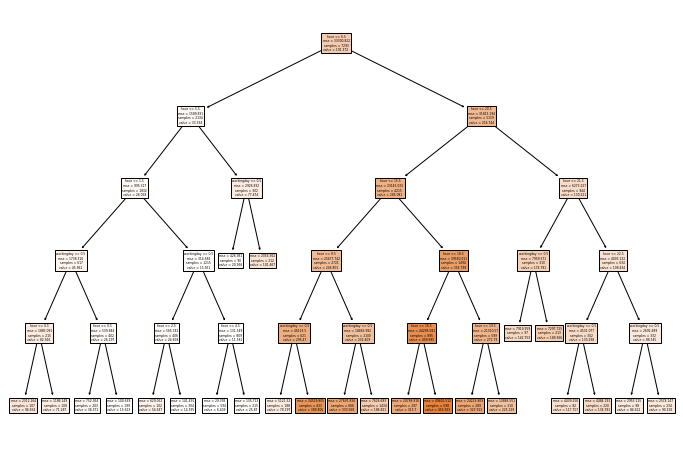

In [70]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plot_tree(decision_tree= modelibreria,feature_names=X_train.columns , filled=True);

In [71]:
a = X_train.sample()
a

,const,workingday,hour
datetime,,,
2012-06-05 02:00:00,1.0,1,2


In [72]:
ypredict = modelibreria.predict(X_train)

In [73]:
from sklearn.metrics import mean_squared_error ,mean_absolute_error, explained_variance_score

print( "El coeficiente de determinacion R2 es : %.2f "% modelibreria.score(X_train,y_train))
print( "El MAE es :", mean_absolute_error(y_train,ypredict))   
print ( "El MSE es ", mean_squared_error(y_train,ypredict)) 
print( "El RMSE es", np.sqrt(mean_squared_error(y_train,ypredict))) 

El coeficiente de determinacion R2 es : 0.60 
El MAE es : 76.82788362704378
El MSE es  13445.326263931616
El RMSE es 115.95398338966892


Con estos resultados de los 2 modelos estimados y ajustando parámetros en ellos . Se observa que el de mejor desempeño es el árbol de decisión . El parámetro ajustado es la profundida , lo cual ayuda a robustecer las métricas estimadas y su interpretación. A comparación del modelo de regresión las métricas son altas por lo que lo hacen mejor modelo con esta base de datos seleccionada.

## Parte B - Métodos de ensamblajes

En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la populridad esta dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el sigueinte enlace: datos.

Datos popularidad de noticias


In [74]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [75]:
# Definición variable de interes y variables predictoras
X2 = df.drop(['url', 'Popular'], axis=1)
y2 = df['Popular']
y2.mean()
X2

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,2.0,...,0.470000,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8
1,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,0.0,...,0.342778,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1
2,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,0.0,...,0.516263,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0
3,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,0.0,...,0.436654,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0
4,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,0.0,...,0.346429,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,523.0,10.0,660.0,0.493884,1.0,0.633971,20.0,4.0,1.0,0.0,...,0.311531,0.050000,0.50,-0.258730,-0.80,-0.100000,0.1,0.0,0.4,0.0
5996,139.0,9.0,144.0,0.647887,1.0,0.739583,15.0,4.0,10.0,1.0,...,0.287273,0.100000,0.60,-0.250000,-0.30,-0.200000,0.0,0.0,0.5,0.0
5997,623.0,8.0,536.0,0.512287,1.0,0.647929,6.0,2.0,1.0,1.0,...,0.304167,0.100000,0.40,-0.156250,-0.30,-0.100000,0.0,0.0,0.5,0.0
5998,584.0,10.0,266.0,0.534413,1.0,0.605882,9.0,6.0,1.0,0.0,...,0.304924,0.100000,0.60,-0.250000,-0.40,-0.100000,0.0,0.0,0.5,0.0


In [76]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X2, y2, random_state=1)
Xtrain

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
2420,287.0,10.0,794.0,0.480720,1.0,0.712589,11.0,1.0,10.0,0.0,...,0.425597,0.062500,1.0,-0.227238,-0.5,-0.050000,0.000000,0.000000,0.500000,0.000000
1225,265.0,8.0,748.0,0.460114,1.0,0.582809,16.0,2.0,16.0,0.0,...,0.318308,0.083333,0.7,-0.473413,-0.7,-0.100000,0.400000,0.100000,0.100000,0.100000
324,375.0,12.0,2104.0,0.341929,1.0,0.508544,61.0,14.0,32.0,0.0,...,0.432095,0.033333,1.0,-0.236244,-0.8,-0.050000,0.454545,0.136364,0.045455,0.136364
5863,388.0,9.0,1281.0,0.461039,1.0,0.647832,36.0,33.0,14.0,0.0,...,0.452616,0.033333,1.0,-0.188155,-0.4,-0.050000,0.000000,0.000000,0.500000,0.000000
86,627.0,10.0,306.0,0.530612,1.0,0.601010,13.0,1.0,9.0,0.0,...,0.415417,0.100000,1.0,-0.292361,-0.6,-0.066667,0.357143,0.000000,0.142857,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,212.0,11.0,549.0,0.528545,1.0,0.667614,11.0,2.0,1.0,0.0,...,0.373900,0.062500,0.6,-0.356667,-0.6,-0.166667,0.800000,0.250000,0.300000,0.250000
5192,78.0,10.0,317.0,0.691489,1.0,0.793269,14.0,3.0,1.0,24.0,...,0.361364,0.200000,0.7,-0.278472,-0.4,-0.125000,0.500000,0.500000,0.000000,0.500000
3980,430.0,11.0,1105.0,0.413632,1.0,0.612903,8.0,4.0,1.0,0.0,...,0.359703,0.062500,1.0,-0.258218,-0.7,-0.025000,0.000000,0.000000,0.500000,0.000000
235,309.0,9.0,1129.0,0.455046,1.0,0.623894,20.0,1.0,11.0,1.0,...,0.466204,0.100000,1.0,-0.334791,-1.0,-0.071429,1.000000,0.850000,0.500000,0.850000


## Punto 6 - Árbol de decisión y regresión logística


En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [77]:
#Arbol de decision

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    primermodelo = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(primermodelo, Xtrain, ytrain, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

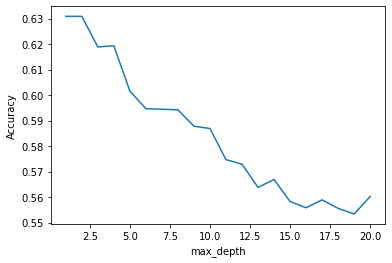

In [78]:
# Gráfica max_depth versus RMSE (error del modelo)

# Gráfica del salario, años y hits
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [79]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth

sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.6308888888888888, 2)

In [80]:
# max_depth=2 fue el mejor, se ajusta un árbol usando este valor 
primermodelo1 = DecisionTreeClassifier(max_depth=2, random_state=1)
primermodelo1.fit(Xtrain, ytrain)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

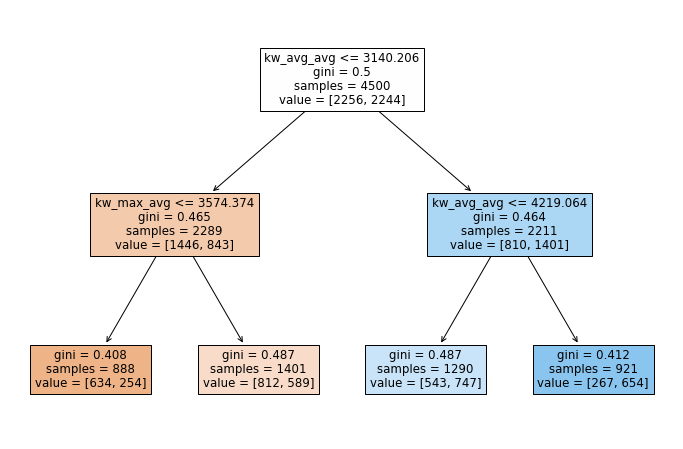

In [81]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plot_tree(decision_tree= primermodelo1,feature_names=Xtrain.columns , filled=True);

In [82]:
#Accurarcy con F1 Score
y_predAD = primermodelo1.predict(Xtest)
metrics.f1_score(y_predAD, ytest), metrics.accuracy_score(y_predAD, ytest)

(0.6448598130841121, 0.6453333333333333)

In [83]:
# Regresion 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Creación del modelo utilizando matrices como en scikitlearn
# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo

Xtrain = sm.add_constant(Xtrain, prepend=True)
modelo = sm.Logit(endog=ytrain, exog=Xtrain,)
modelo = modelo.fit()
print(modelo.summary())

         Current function value: 0.629170
         Iterations: 35


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                Popular   No. Observations:                 4500
Model:                          Logit   Df Residuals:                     4444
Method:                           MLE   Df Model:                           55
Date:                Mon, 04 Apr 2022   Pseudo R-squ.:                 0.09229
Time:                        00:34:47   Log-Likelihood:                -2831.3
converged:                      False   LL-Null:                       -3119.1
Covariance Type:            nonrobust   LLR p-value:                 7.356e-88
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -1.5475   1.41e+06   -1.1e-06      1.000   -2.76e+06    2.76e+06
timedelta                         0.0006      0.000      2.609      0.009 

In [84]:
# Predicciones con intervalo de confianza 
# ==============================================================================
predicciones1 = modelo.predict(exog = Xtrain)

In [85]:
# Clasificación predicha
# ==============================================================================
clasificacionlogit = np.where(predicciones1<0.5, 0, 1)
clasificacionlogit

array([1, 1, 1, ..., 1, 1, 0])

In [89]:
# Accuracy de test del modelo 
# ==============================================================================
Xtest = sm.add_constant(Xtest, prepend=True)
prediccionestest = modelo.predict(exog = Xtest)
clasificaciontest = np.where(prediccionestest<0.5, 0, 1)
accuracytest = accuracy_score(
            y_true    = ytest,
            y_pred    = clasificaciontest,
            normalize = True
           )
F1test = metrics.f1_score(
            y_true    = ytest,
            y_pred    = clasificaciontest
           )
print("")
print(f"El accuracy de test es: {accuracytest}")
print(f"El F1 de test es: {F1test}")


El accuracy de test es: 0.6426666666666667
El F1 de test es: 0.6323731138545953


Para estos 2 modelos de clasificación se obtienen metricas similares que dificultarian la elección de alguno de ellos . Sin embargo si nos vamos a las métricas puntualmente, el mejor modelo sería el de arbol por tener un F1 de 0.64 mayor al de regresión logistica.

## Punto 7 - Votación Mayoritaria

En la celda 7 elabore un esamble con la metodología de Votación mayoritaria compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth = None\ -100 árboles de decisión donde max_depth = 2\ -100 regresiones logísticas

Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

In [109]:
#100 árboles de decisión donde max_depth = None

# Definición del modelo BaggingClassifier de la libreria sklearn
from sklearn.ensemble import BaggingClassifier

escenario1 = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=None), n_estimators=300, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

In [110]:
# Predicción y desempeño al hacer votación mayoritaria
from sklearn import metrics

escenario1.fit(Xtrain, ytrain)
y_predVM = escenario1.predict(Xtest)
F1None = metrics.f1_score(y_predVM, ytest)
AccuracyNone= metrics.accuracy_score(y_predVM, ytest)

F1None,AccuracyNone

(0.6516853932584269, 0.6486666666666666)

In [111]:
#100 árboles de decisión donde max_depth = 2

escenario2 = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=300, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

In [112]:
# Predicción y desempeño al hacer votación mayoritaria
escenario2.fit(Xtrain, ytrain)
y_predVM2 = escenario2.predict(Xtest)
F1Max2 =metrics.f1_score(y_predVM2, ytest)
AccuracyMax2= metrics.accuracy_score(y_predVM2, ytest)

F1Max2,AccuracyMax2

(0.6447721179624666, 0.6466666666666666)

In [100]:
#100 regresiones logisticas

# Definición del modelo Regresionlogistica de la libreria sklearn

#from sklearn.ensemble import LogisticRegression
from sklearn.linear_model import LogisticRegression

escenario3 = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=300, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

In [113]:
# Predicción y desempeño al hacer votación mayoritaria
escenario3.fit(Xtrain, ytrain)
y_predVM3 = escenario3.predict(Xtest)
F1logit=metrics.f1_score(y_predVM3, ytest)
Accuraylogit=metrics.accuracy_score(y_predVM3, ytest)

F1logit,Accuraylogit

(0.6134055517941774, 0.6193333333333333)

## Punto 8 - Votación Ponderada

En la celda 8 elabore un ensamble con la metodología de Votación ponderada compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [123]:
#100 árboles de decisión donde max_depth = None

n_estimators=300

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(escenario1.n_estimators)
y_pred_all_ = np.zeros((Xtest.shape[0], escenario1.n_estimators))

for i in range(escenario1.n_estimators):
    oob_sample = ~escenario1.estimators_samples_[i]
    y_pred_ = escenario1.estimators_[i].predict(Xtrain.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, ytrain.values[oob_sample])
    y_pred_all_[:, i] = escenario1.estimators_[i].predict(Xtest)
    
alpha = (1 - errors) / (1 - errors).sum()
y_predVP = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

In [124]:
# Desempeño al hacer votación ponderada
F1PNone=metrics.f1_score(y_predVP, ytest)
AccuracyPNone= metrics.accuracy_score(y_predVP, ytest)

F1PNone , AccuracyPNone

(0.6513157894736842, 0.6466666666666666)

In [125]:
#100 árboles de decisión donde max_depth = 2


# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(escenario2.n_estimators)
y_pred_all_ = np.zeros((Xtest.shape[0], escenario2.n_estimators))

for i in range(escenario2.n_estimators):
    oob_sample = ~escenario2.estimators_samples_[i]
    y_pred_ = escenario2.estimators_[i].predict(Xtrain.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, ytrain.values[oob_sample])
    y_pred_all_[:, i] = escenario2.estimators_[i].predict(Xtest)
    
alpha = (1 - errors) / (1 - errors).sum()
y_predVP1 = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

In [126]:
# Desempeño al hacer votación ponderada
F1PMax2= metrics.f1_score(y_predVP1, ytest)

AccuracyPMax2= metrics.accuracy_score(y_predVP1, ytest)

F1PMax2 , AccuracyPMax2

(0.6443850267379679, 0.6453333333333333)

In [127]:
#100 árboles de Logistic


# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(escenario3.n_estimators)
y_pred_all_ = np.zeros((Xtest.shape[0], escenario3.n_estimators))

for i in range(escenario3.n_estimators):
    oob_sample = ~escenario3.estimators_samples_[i]
    y_pred_ = escenario3.estimators_[i].predict(Xtrain.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, ytrain.values[oob_sample])
    y_pred_all_[:, i] = escenario3.estimators_[i].predict(Xtest)
    
alpha = (1 - errors) / (1 - errors).sum()
y_predVP3 = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

In [128]:
# Desempeño al hacer votación ponderada
F1PLogit= metrics.f1_score(y_predVP3, ytest)
AccuracyPLogit= metrics.accuracy_score(y_predVP3, ytest)

F1PLogit , AccuracyPLogit

(0.6121621621621622, 0.6173333333333333)

## Punto 9 - Comparación y análisis de resultados

En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

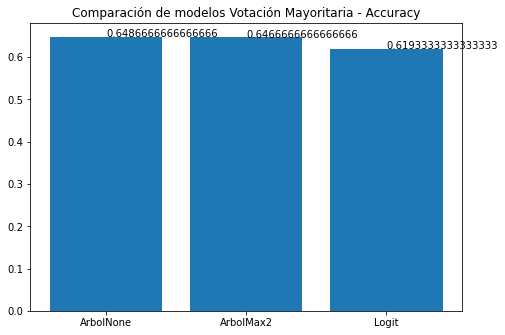

In [129]:

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos Votación Mayoritaria - Accuracy")
ejeX = ['ArbolNone','ArbolMax2' ,'Logit']
ejeY = [AccuracyNone,AccuracyMax2,Accuraylogit]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()

Para los modelos estimados por Votación Mayoritaria el que tuvo un mejor Accuracy fue el arbol de decisión en donde no se definió una profundidad definida. Esto corroboraría la teoría en donde posiblemente este árbol de decisión pueda aumentar su predictividad reduciendo la varianza aumentando la profundidad del mismo y al no estar definida da un poco mejor que cuando se deja el parámetro en Max_depth = 2.

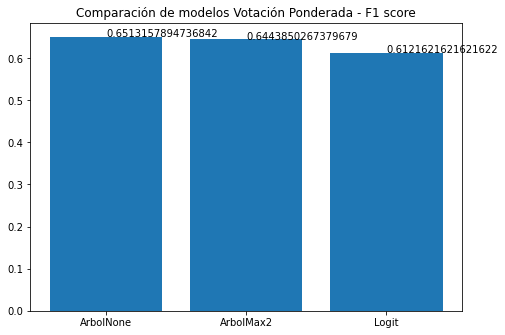

In [130]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos Votación Ponderada - F1 score")
ejeX = ['ArbolNone','ArbolMax2' ,'Logit']
ejeY = [F1PNone,F1PMax2,F1PLogit]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()

Para los modelos estimados por Votación Ponderada, y mirando para esta ocasión el F1 score, el modelo que tuvo mejor desempeño fue de igual manera el el arbol de decisión en donde no se definió una profundidad definida. Y se sustenta los datos arrojados con lo anteriormente mencionado.

En conclusión general , cada uno de estos métodos aporta en mejorar o desmejorar la estimación que se realiza por lo que es oportuno realizarlos para poder comprar y así definir el mejor modelo con el método que corresponda y obtener las mejores predicciones posibles.